In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import collections
from functools import partial
import csv


##Preprocessing

#####Load data

######Helpers

In [ ]:
######helpers

def load_columns_name(path):
  with open(path) as f:
    cols = f.readline()
    cols = cols.split(',')[2:]
    cols[-1] = cols[-1][:-1]
    return cols

def load_features(path):
    x = np.genfromtxt(path, delimiter=",", skip_header=1)
    return x[:, 2:]

def load_labels(path):
    y = np.genfromtxt(path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1
    return yb

def load_ids(path):
  return np.genfromtxt(path, delimiter=",", skip_header=1, usecols=0)

def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in .csv format for submission to Kaggle or AIcrowd
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})
            
###represent a dataset, a we need to train a model and uderstand the features
class Dataset:

  def __init__(self):
    self.x = None
    self.y = None
    self.feature_name = None
  
  def with_values(self, x, y, feature_name):
    self.x = x
    self.y = y
    self.feature_name = feature_name
    return self

  def from_path(self, path):
    self.x = load_features(path)
    self.y = load_labels(path)
    self.feature_name = load_columns_name(path)
    return self
  
  def __repr__(self):
    return f'features: {self.feature_name}'

  def split(self, ratio):
    shuffled = np.random.permutation(len(self.y))

    split_idx = int(ratio*len(self.y))
    train, test = shuffled[:split_idx], shuffled[split_idx:]

    train_ds =  Dataset().with_values(self.x[train], self.y[train], self.feature_name)
    test_ds =  Dataset().with_values(self.x[test], self.y[test], self.feature_name)

    return train_ds, test_ds

  def plot_box(self, feature_index, ax):
    ax.set_title(self.feature_name[feature_index])
    ax.boxplot(self.x[:,feature_index])
  
  def plot_hist(self, feature_index, ax):
    ax.set_title(self.feature_name[feature_index])
    ax.hist(self.x[:,feature_index], bins = 40)
  
  def scatter_plot(self, feature_1 : int, feature_2 : int, ax):
    ax.set_xlabel(self.feature_name[feature_1])
    ax.set_ylabel(self.feature_name[feature_2])
    

    ax.scatter(self.x[:,feature_1], self.x[:,feature_2])




######Main code

In [ ]:
####ifrst you need to have 
#/content/drive/MyDrive/dataset/train.csv.zip
with zipfile.ZipFile('./dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

path_data = 'dataset/train.csv'

dataset = Dataset().from_path(path_data)
dataset

features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

#####Feature analysis

######Helpers

In [ ]:
def make_plot(plotting_function):
   fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7.5))
   plotting_function(ax)
   ax.yaxis.label.set_size(14)
   ax.xaxis.label.set_size(14)
   return fig, ax


###works only for 30 features
def plot_all_features(plotting_function):
  width = 2*6.4
  height = 8 * 4.8

  fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(width, height))

  for i, ax in enumerate(axs.ravel()):
    ax = plotting_function(i, ax)

def plot_distribution():
  plot_all_features(dataset.plot_hist)

def box_plot():
  plot_all_features(dataset.plot_box)



######Main code

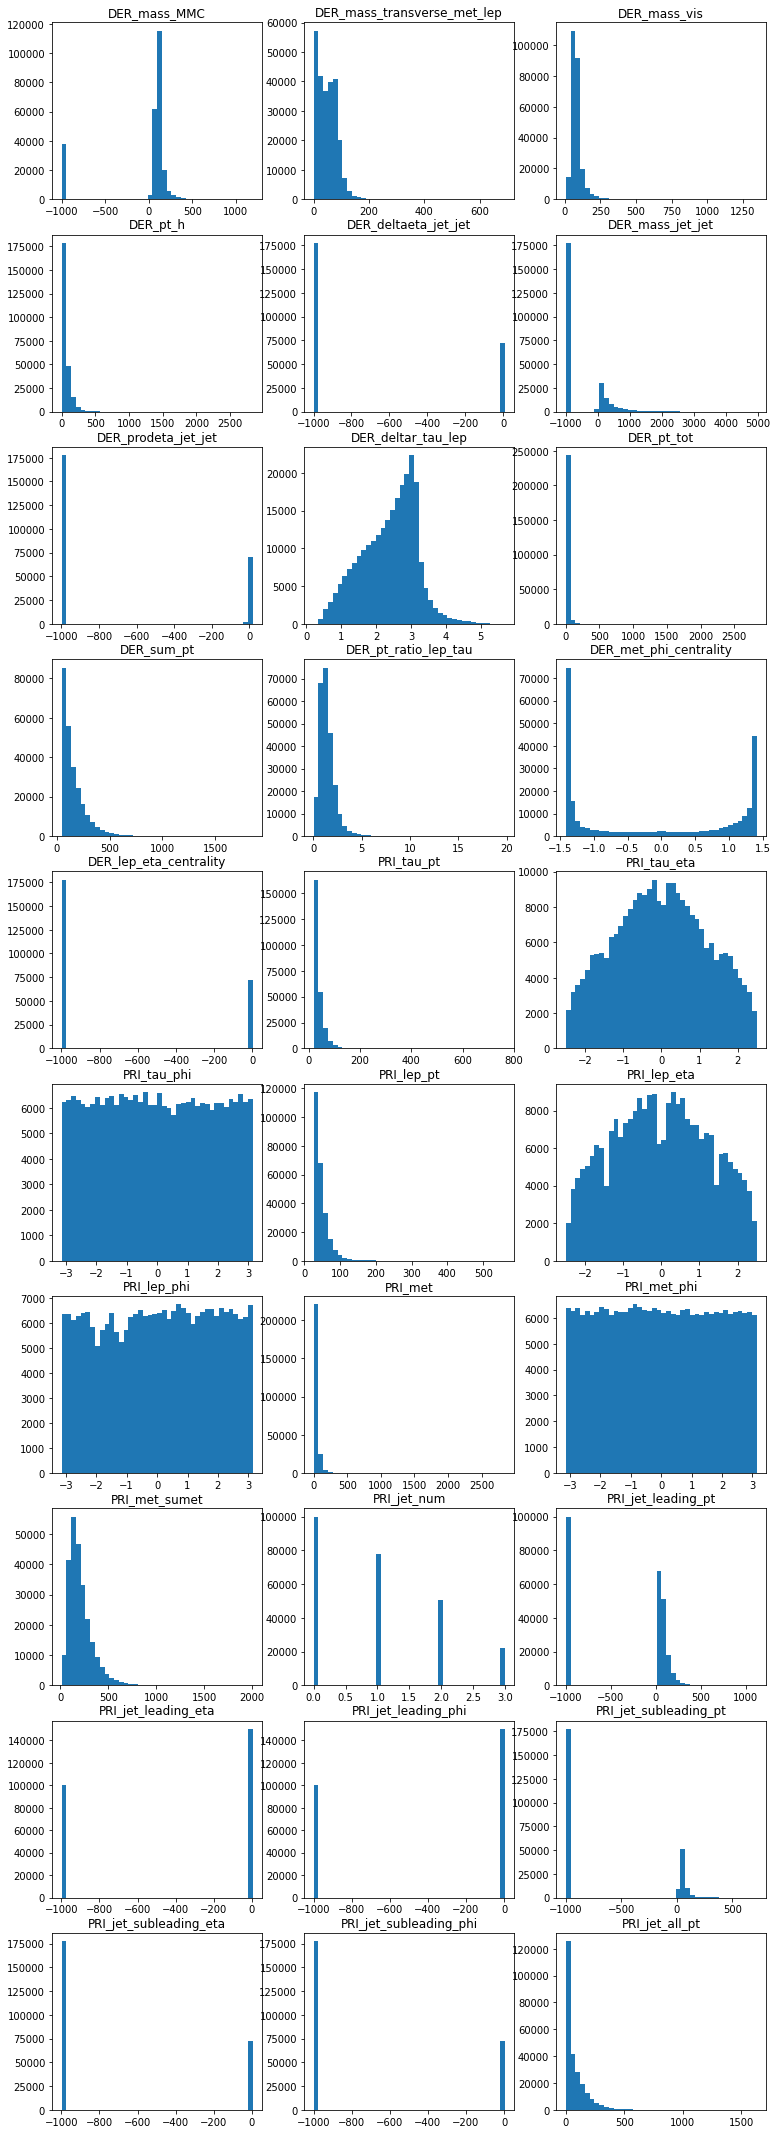

In [ ]:
plot_distribution() 

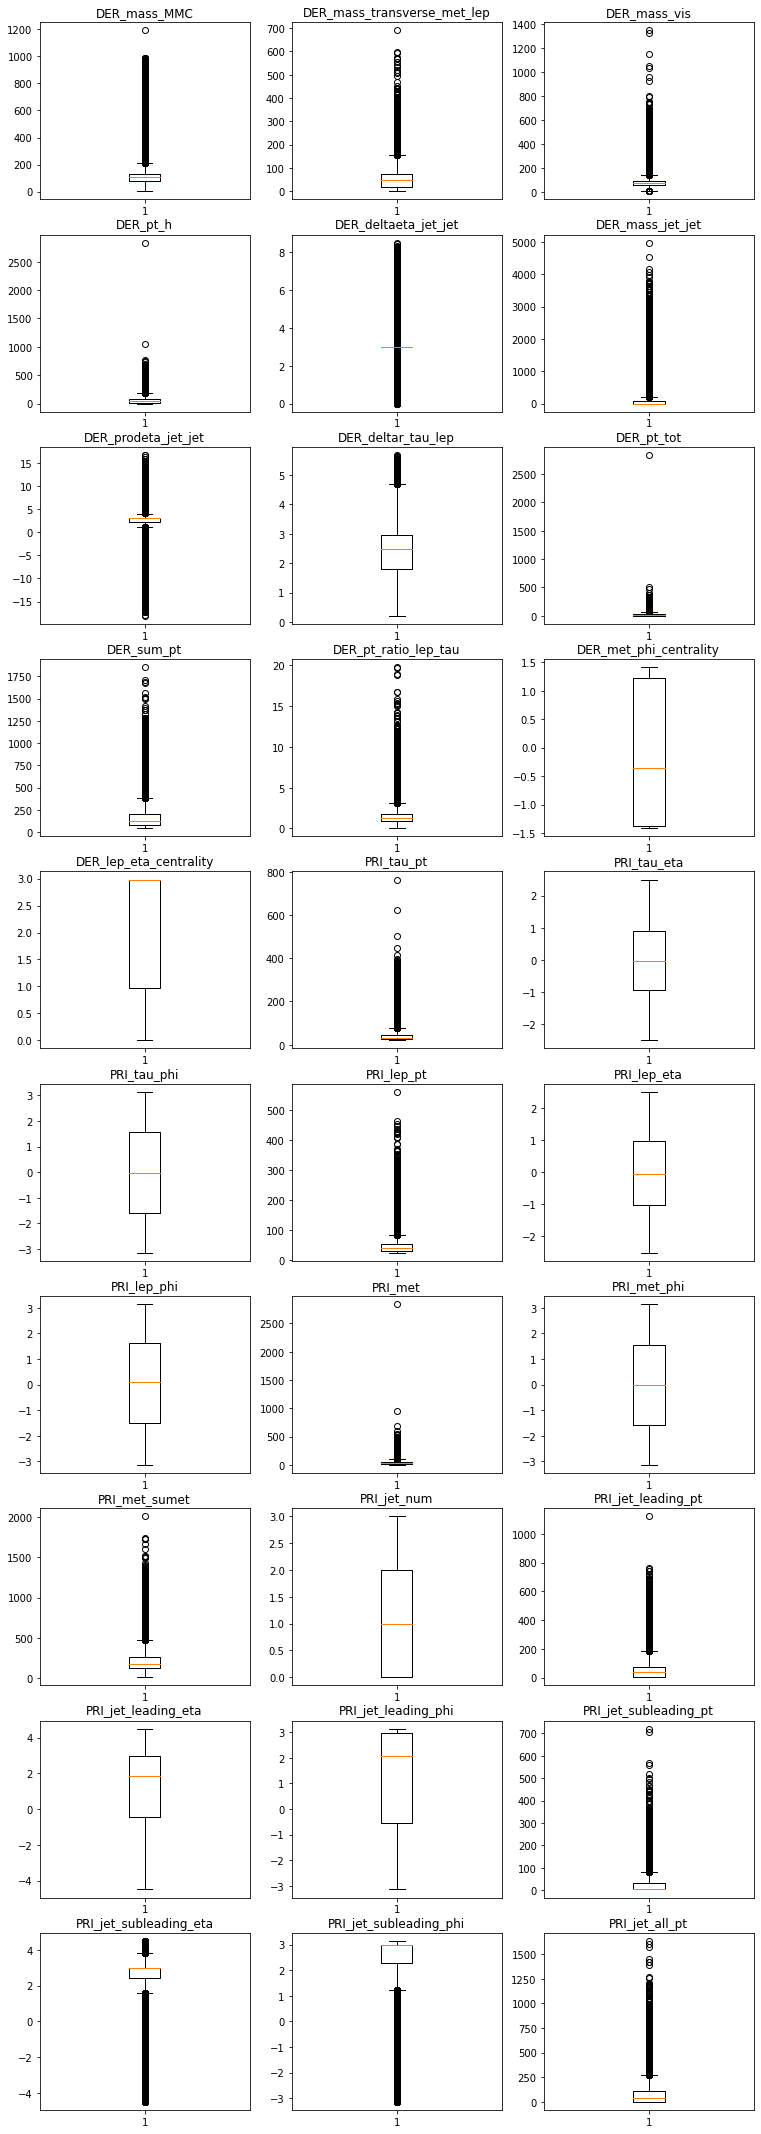

In [ ]:
box_plot()

#####Dependency analysis


In [ ]:
#### we analyse the dependecy between variables
def correlation(feature_1 : int, feature_2 : int):
  f_1, f_2 = dataset.x[:,feature_1], dataset.x[:,feature_2]
  
  f_1_2 = (f_1*f_2).mean()
  std = f_1.std()*f_2.std()

  return (f_1_2 - f_1.mean()*f_2.mean())/std



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


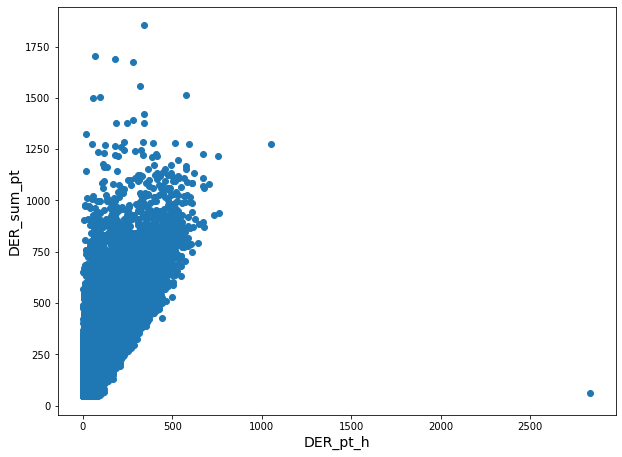

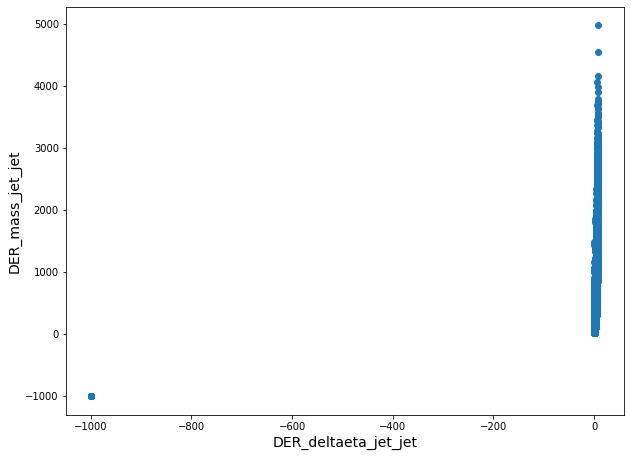

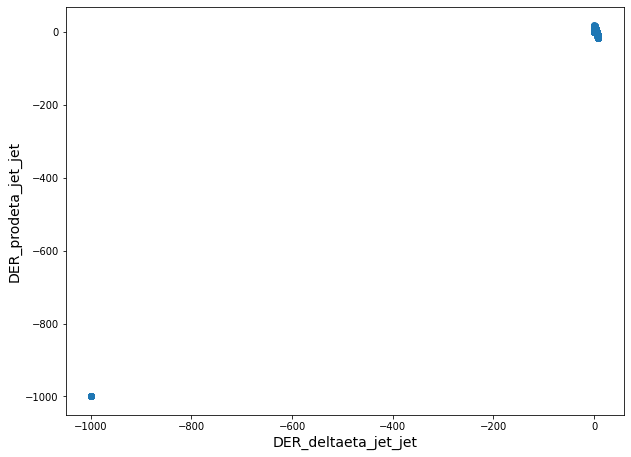

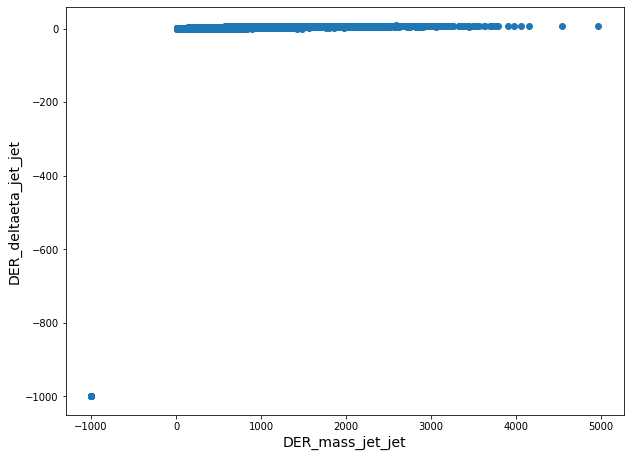

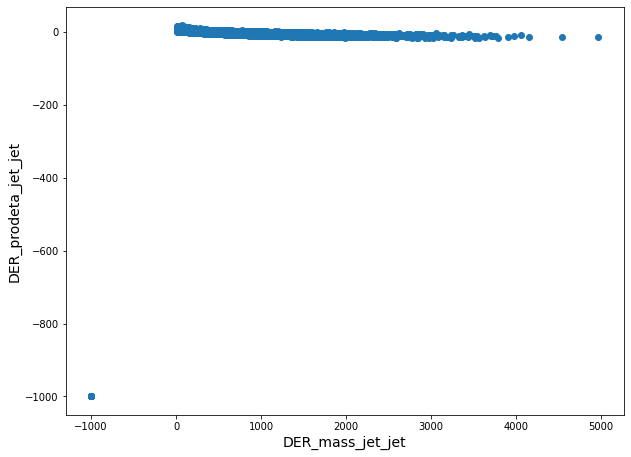

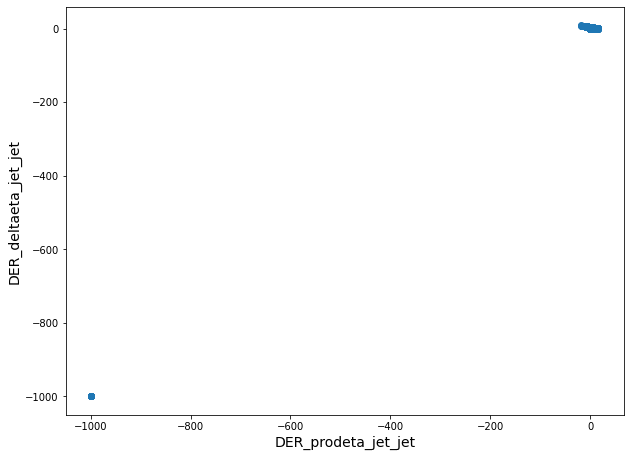

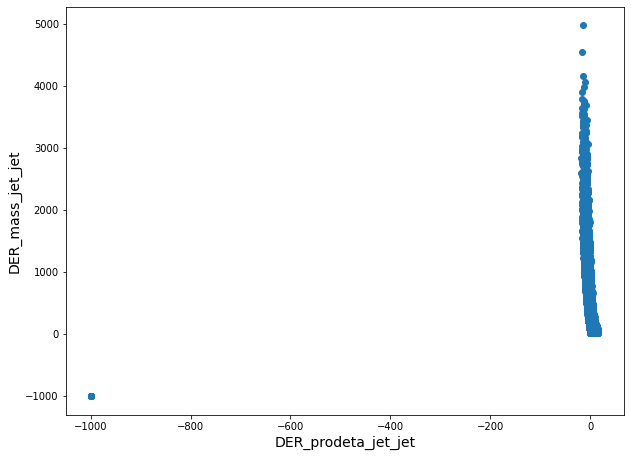

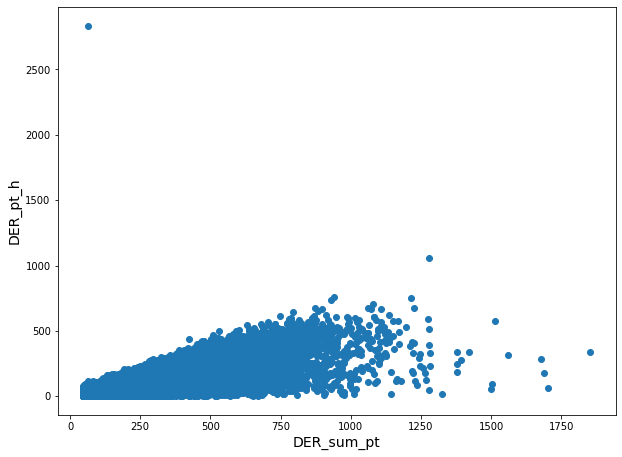

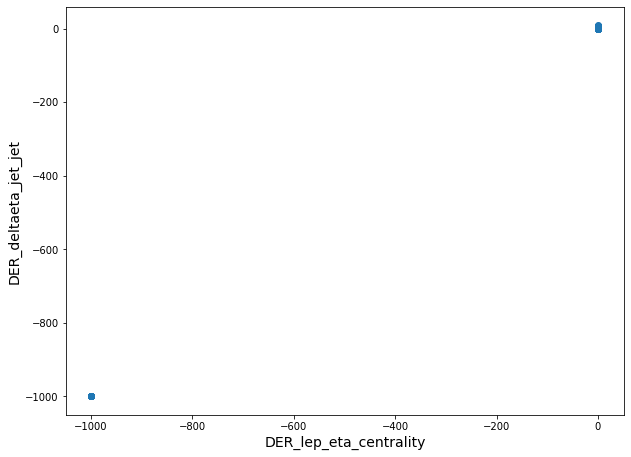

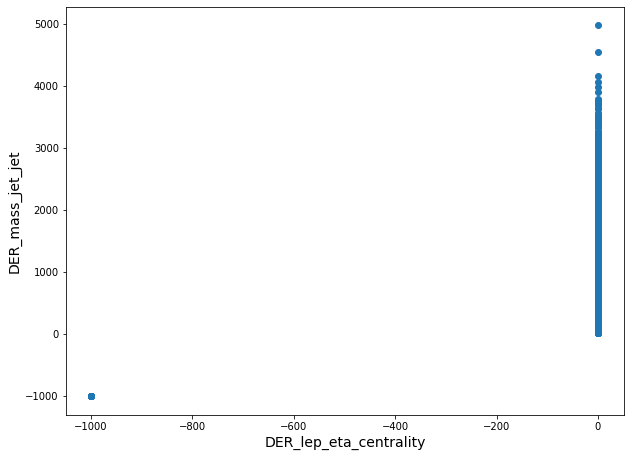

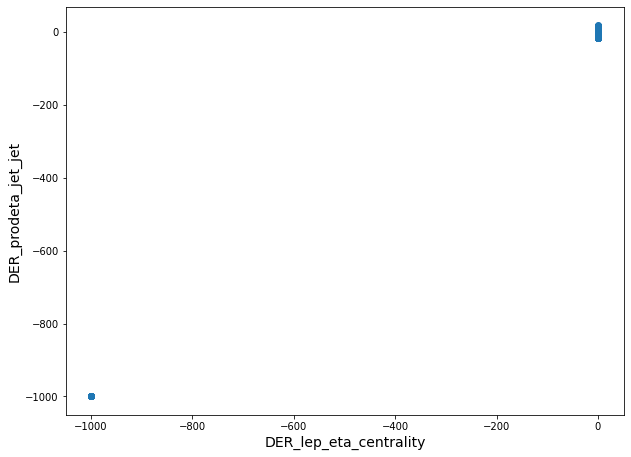

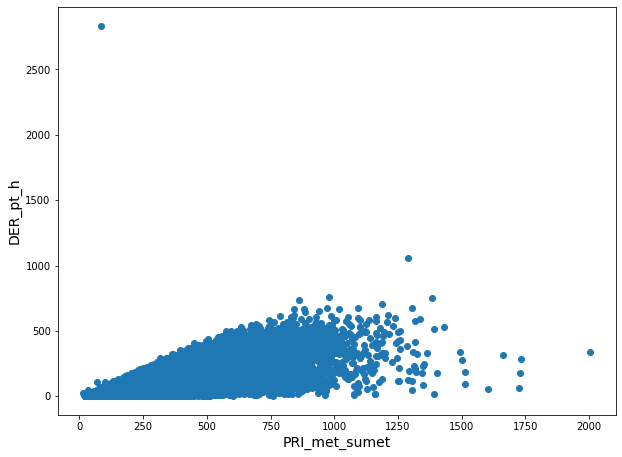

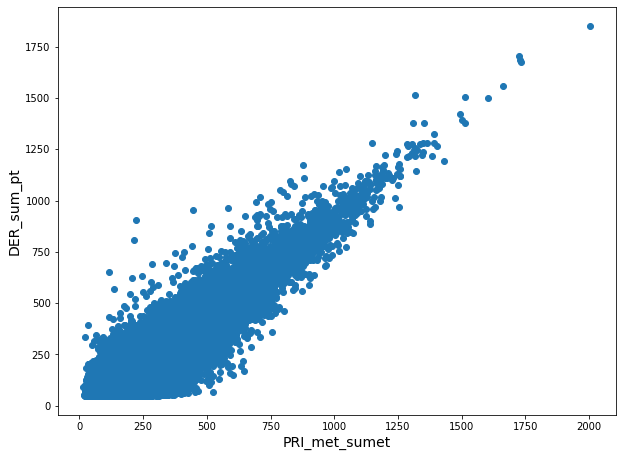

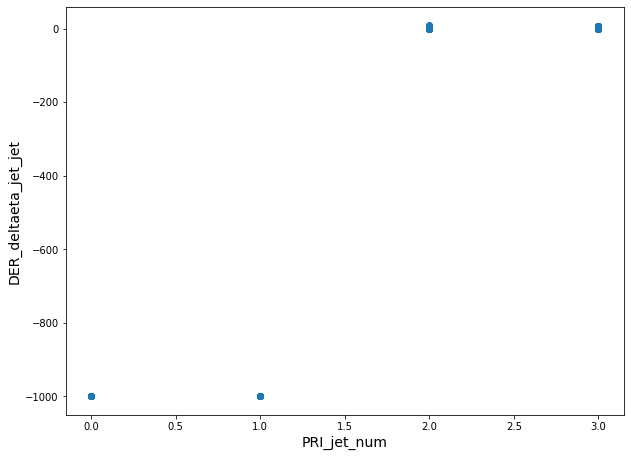

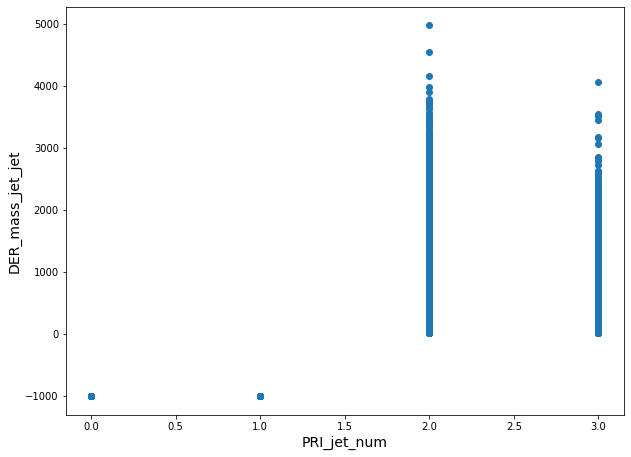

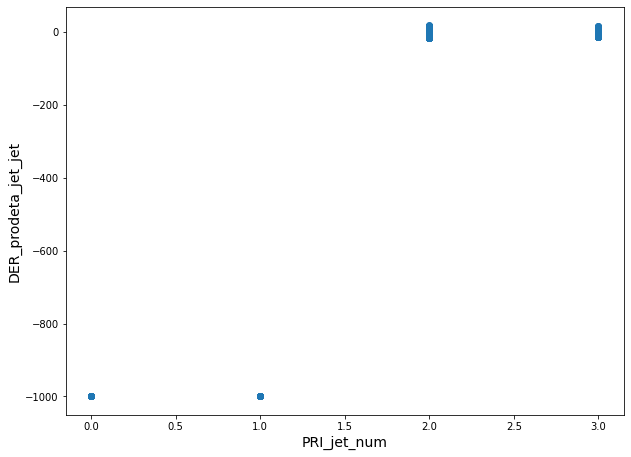

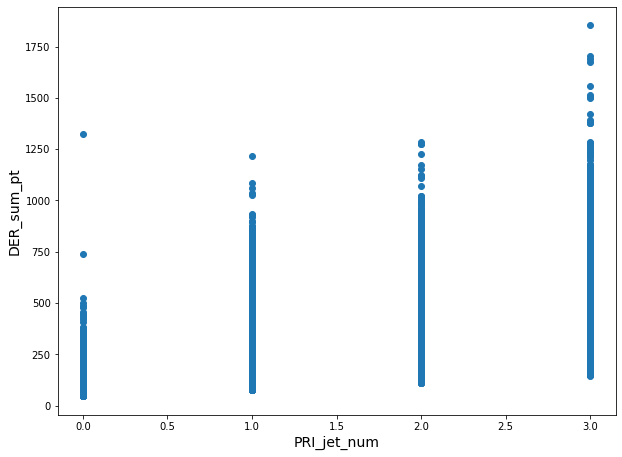

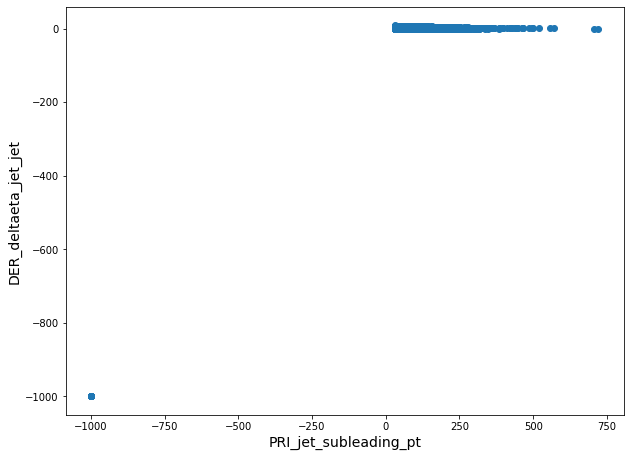

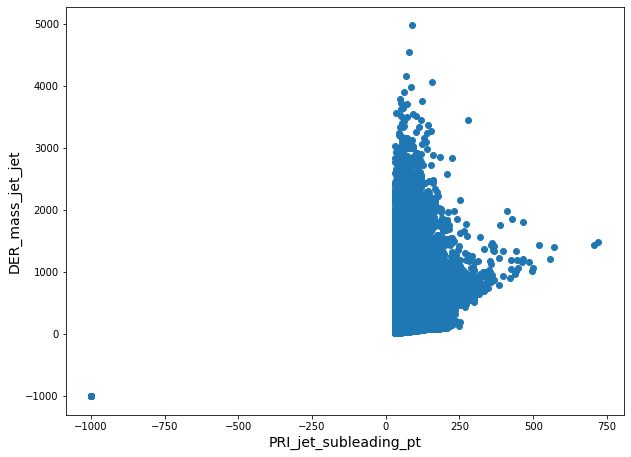

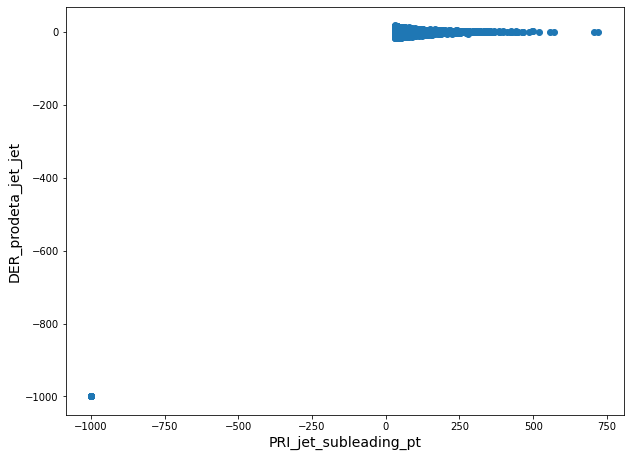

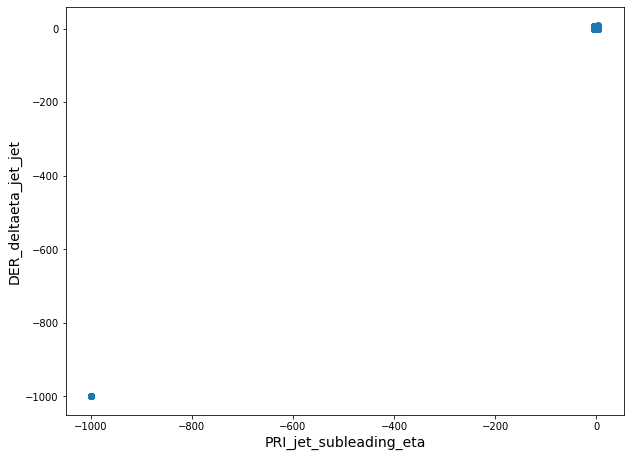

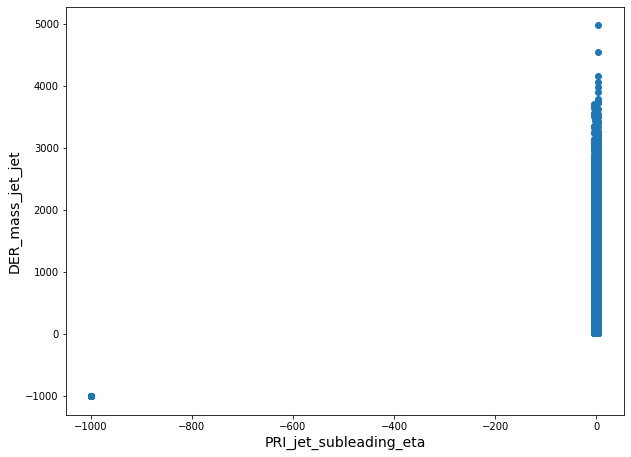

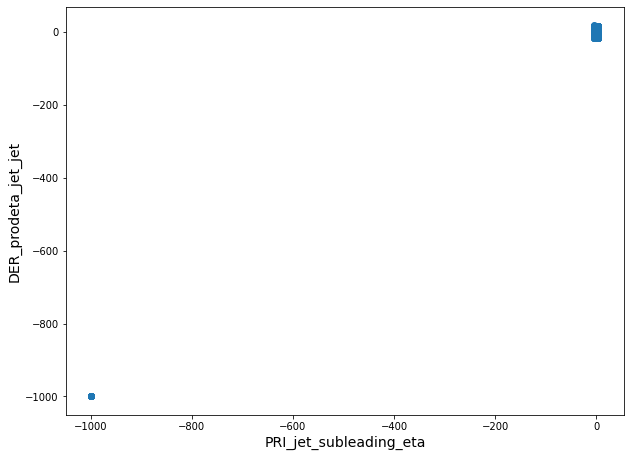

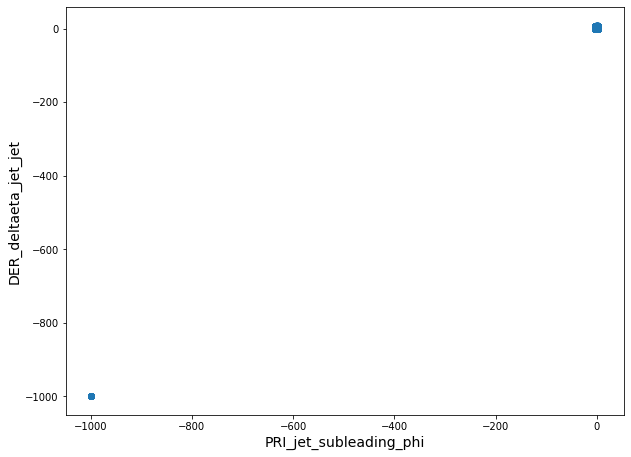

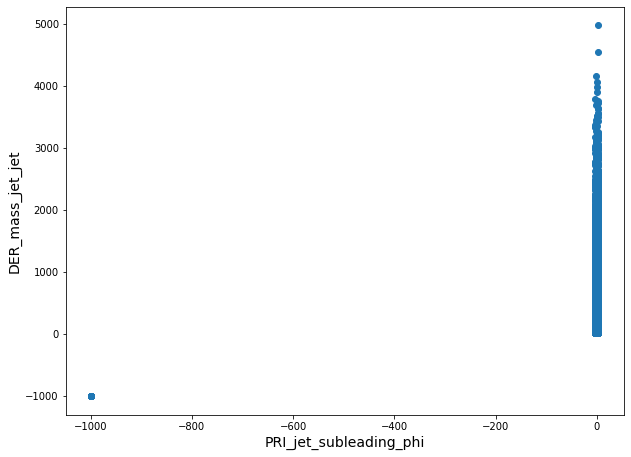

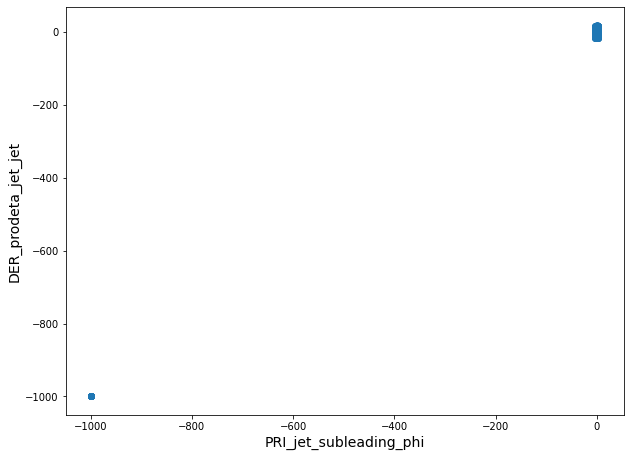

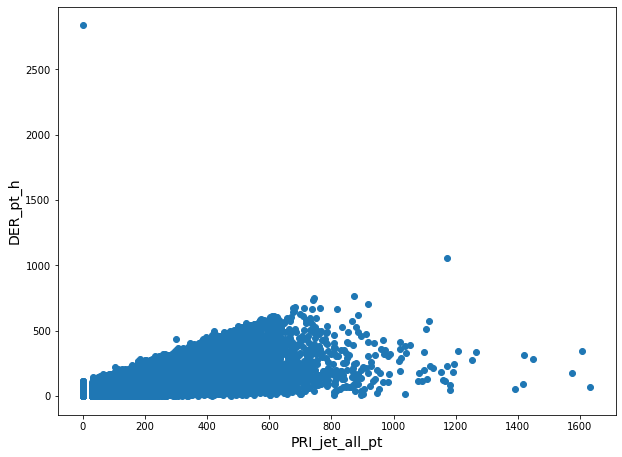

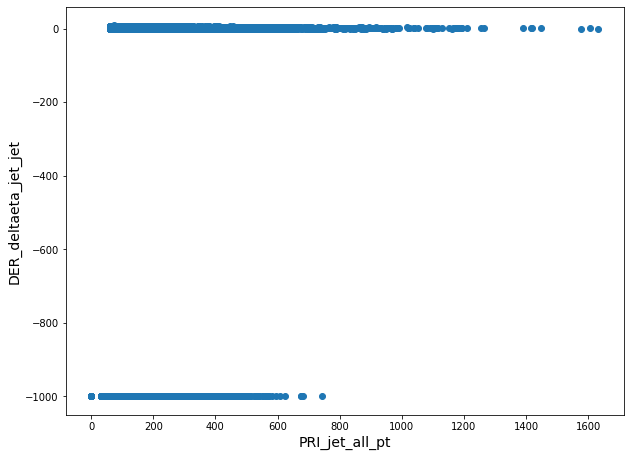

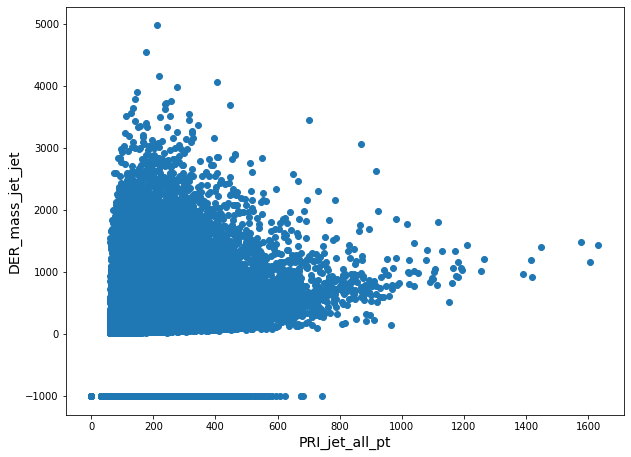

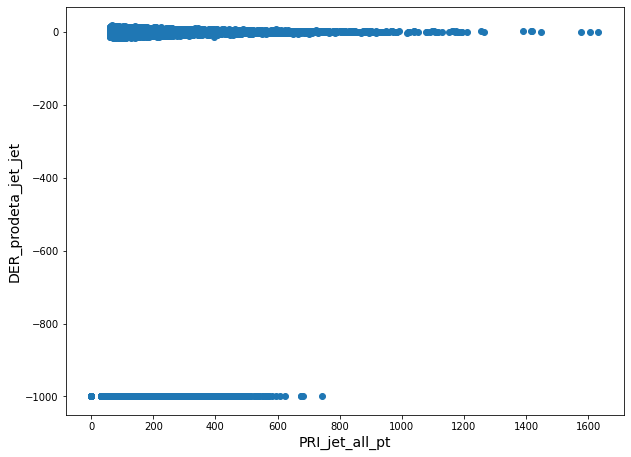

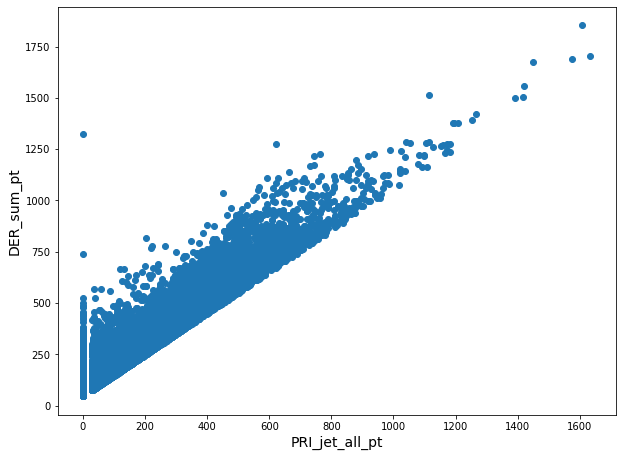

In [ ]:
features_pair = [ (a,b) for a in range(30) for b in range(10 ) if not a==b]

for a,b in features_pair:
  corr = correlation(a, b)
  if corr>0.7:
    make_plot(partial(dataset.scatter_plot, a, b))

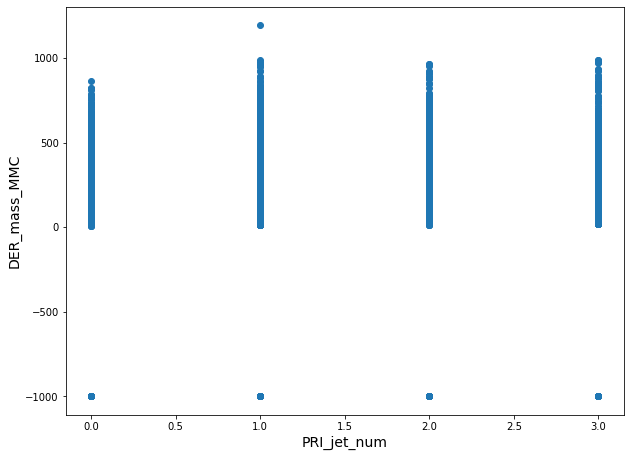

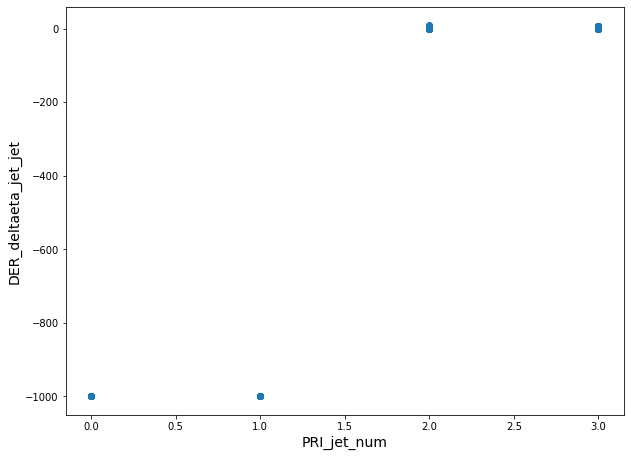

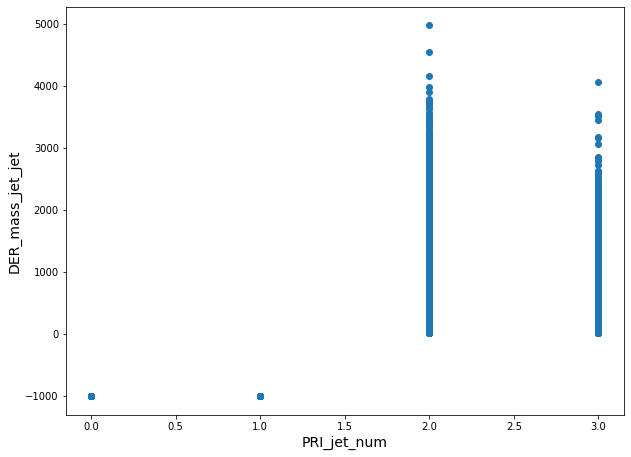

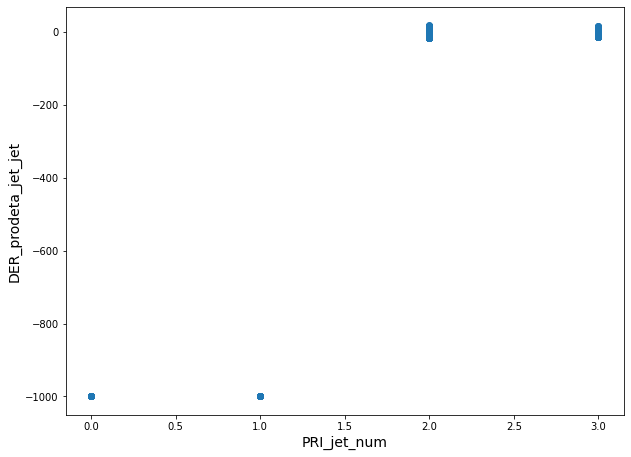

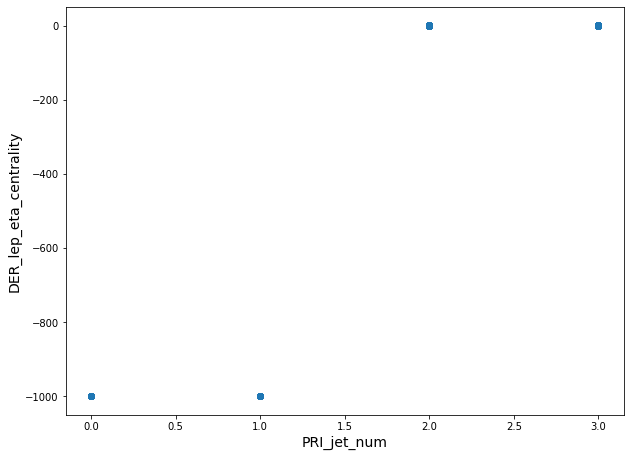

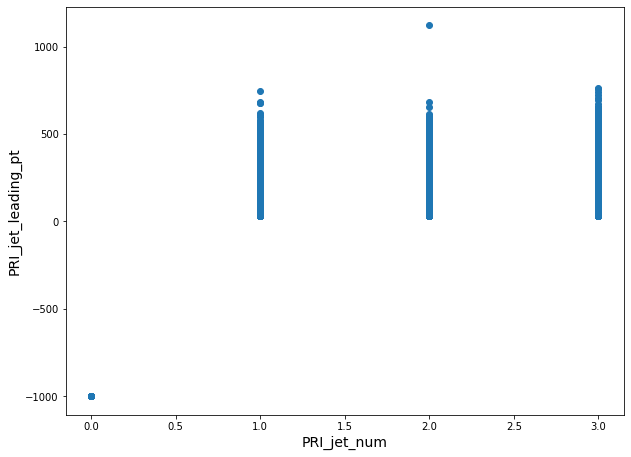

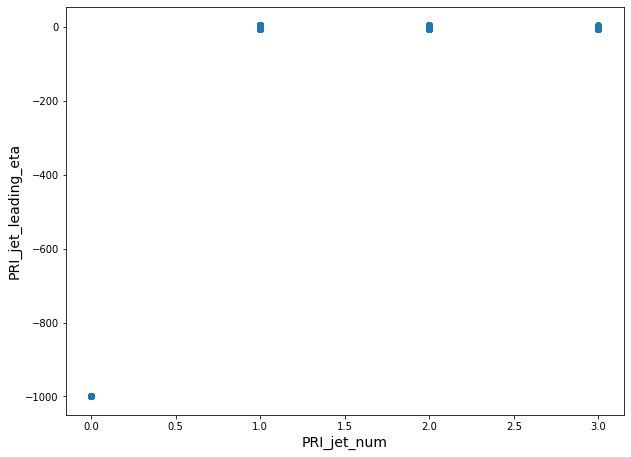

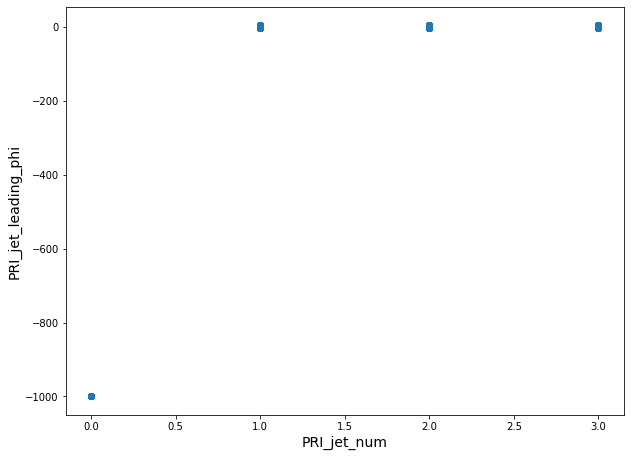

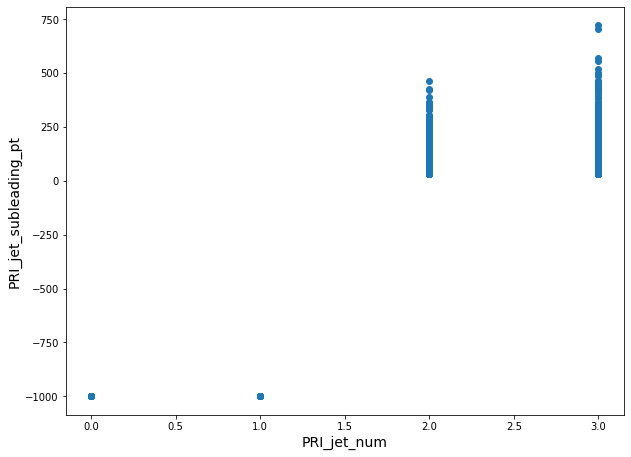

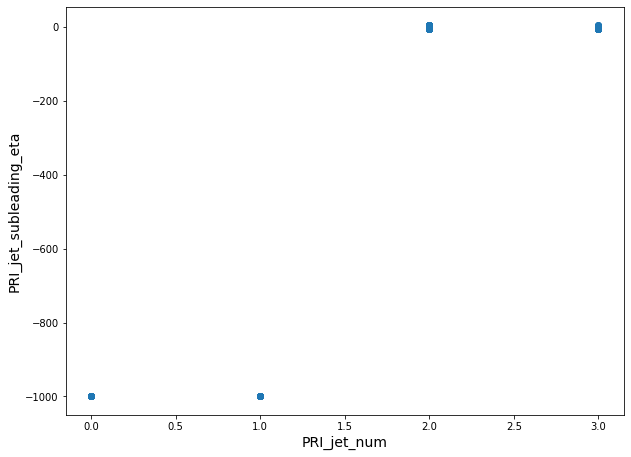

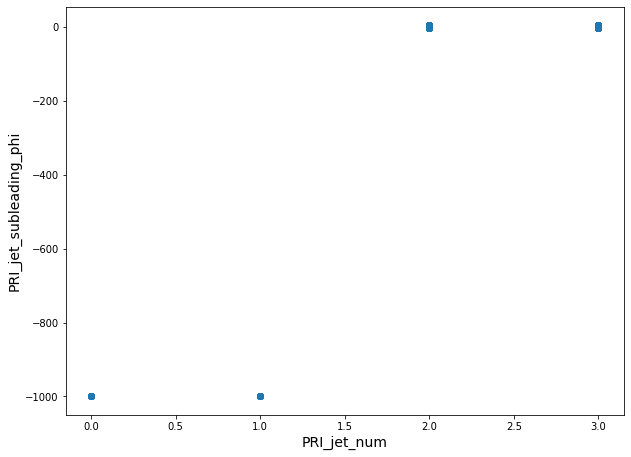

In [ ]:
features_pair = [ (22,a) for a in range(30) if np.any(dataset.x[:,a]<=-998) ]
for a, b in features_pair:
    make_plot(partial(dataset.scatter_plot, a, b))

#####Replace Nan (wrong samples)

In [ ]:
####We clean and normalize the data

### we use median as it is robust to power laws
def replace_wrong_data(dataset):
  wrong_samples = dataset.x<=-999
  dataset.x[wrong_samples] = np.median(dataset.x[~wrong_samples], axis=0)

replace_wrong_data(dataset)

##Training

###Helpers

In [ ]:
def predict_label(y, threshold=0):
  predictions = np.ones((len(y)))
  predictions[y<threshold] = -1
  return predictions

def accuracy(y, y_pred):
  return np.mean(y == y_pred)

#we define the function eval_model that allow us to evaluate more easily our model in the future giving back both accuacies and losses
#once we specify the model, the optimization function and the type of preprocessing we want to use
def eval_model(train_dataset, 
               test_dataset,
               model, 
               preprocess,
               opti_function,
               print_result = True):
  
  train_dataset = preprocess(train_dataset)
  test_dataset = preprocess(test_dataset)
  
  w, _ = opti_function(train_dataset.y, train_dataset.x)

  y_train, loss_train = model(w, train_dataset.x, train_dataset.y)
  y_test, loss_test = model(w, test_dataset.x, test_dataset.y)


  acc_train = accuracy(train_dataset.y, y_train)
  acc_test = accuracy(test_dataset.y, y_test)

  if print_result:
    print('test results')
    print('###################')
    print(f'train error {loss_train}')
    print(f'test accuracy {acc_test}')
    print('###################')
  
  return w, loss_train, loss_test, acc_train, acc_test


###Baseline

In [ ]:
np.random.seed(2021)
train, test = dataset.split(0.8)
train.x.shape, test.x.shape


((200000, 30), (50000, 30))

In [ ]:
np.random.seed(2021)
train_1, test_2 = dataset.split(0.8)
print(np.all(test_2.x==test.x))

True


In [ ]:
def linear_model(w, tx, y, threshold=0):
  return predict_label(tx@w, threshold), compute_rmse(y,tx,w)

def no_preprocessing(dataset):
  return dataset

_ = eval_model(train, 
            test, 
            linear_model,
            no_preprocessing,
            opti_function = partial(ridge_regression, lambda_=0)) ## evaluation of ridge regression without any preprocessing of the data

test results
###################
train error 0.8297996771308837
test accuracy 0.74248
###################


###Model selection

####Ridge regression

#####Helpers

In [ ]:
class Normalize_mean:

  def __init__(self):
    self.mean = None
    self.std = None
  
  def __call__(self, dataset):

    if self.mean is None:
      self.mean = np.mean(dataset.x, axis=0)
      self.std = dataset.x.std(axis=0)
      self.std[self.std<0.01] = 1
    
    x = (dataset.x-self.mean)/self.std
    return Dataset().with_values(x,dataset.y,dataset.feature_name)


#####Main code

In [ ]:
normalize = Normalize_mean()

_ = eval_model(train, 
            test, 
            linear_model,
            normalize,
            opti_function = partial(ridge_regression, lambda_=0.0000001))

test results
###################
train error 0.8826211034367475
test accuracy 0.71722
###################


If we only normalize, we get an ill defined matrix, so we need to add a regulariser and it decrease the performance. Normalising does not seem to increase performance. We try different lambdas.

test results
###################
train error 0.829800248886144
test accuracy 0.7425
###################
test results
###################
train error 0.8298002557703207
test accuracy 0.74252
###################
test results
###################
train error 0.8298003054825
test accuracy 0.7425
###################
test results
###################
train error 0.8298009289926555
test accuracy 0.74242
###################
test results
###################
train error 0.8298086394573341
test accuracy 0.74206
###################
test results
###################
train error 0.8298945829854326
test accuracy 0.74172
###################
test results
###################
train error 0.8305985498350444
test accuracy 0.73988
###################
test results
###################
train error 0.8335340427168302
test accuracy 0.73752
###################
test results
###################
train error 0.8385348344199853
test accuracy 0.73684
###################
test results
###################
train error 0.84318

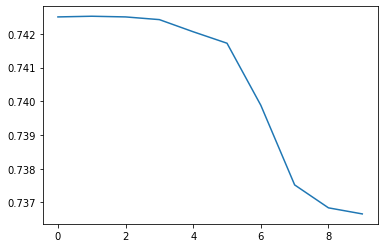

In [ ]:
lambdas_ = np.logspace(-5,0,num=10)
test_accs = []

for lambda_ in lambdas_:
  _, _, _, _, acc_test = eval_model(train, 
            test, 
            linear_model,
            no_preprocessing,
            opti_function = partial(ridge_regression, lambda_=lambda_))
  
  test_accs.append(acc_test)

plt.plot(test_accs)

In [ ]:
print(f'max accuracy {0.7425} max lambda {lambdas_[0]}')

max accuracy 0.7425 max lambda 1e-05


####Logistic regression

#####Helpers

In [ ]:
def gradient_descent(y,  #we define the gradient the function to use in eval_model 
                     x, 
                     loss_function, 
                     grad_function, 
                     max_iters, 
                     gamma, 
                     lambda_, 
                     print_result = True):
  
  w =  np.random.rand(x.shape[1])
  losses = []

  for loop in range(max_iters):
    
   
    w -= gamma*(grad_function(y, x, w) + 2*lambda_*w)

    losses.append(loss_function(y, x, w))
    if loop % 100 == 0 and print_result:
      print(f'loss {losses[-1]}  w norm {np.sqrt(w@w)} gamma {gamma}')
    
  if print_result:
    plt.title('train loss')
    plt.plot(losses) 
    plt.xlabel('steps')
    plt.ylabel('loss')
  
  return w,  losses[-1]

def logistic_model(w, tx, y):
  y_pred = logistic_function(tx@w)

  ####warning y are 0 or 1 and not -1 or 1
  return (predict_label(y_pred, threshold=0.5)+1)/2, calculate_loss(y, tx, w)


def transform_y(dataset):
  y = (dataset.y+1)/2
  return Dataset().with_values(dataset.x, y, dataset.feature_name)

def transform_y_and_normalize():
  ###first we need to change the target from -1,1 to 0,1
  normalize = Normalize_mean()


  ###then we do feature expansion
  return lambda dataset : normalize(transform_y(dataset))


def normalize_with(expansions):
  normalize = Normalize_mean()

  return lambda dataset: normalize(expand_features(dataset, expansions))

#####Main code

We try to train logistic regresion.

loss 3935629.6676308084  w norm 3.37632920178068 gamma 1e-09
loss 971089.1835889687  w norm 3.0731473441784734 gamma 1e-09
loss 829765.2835983466  w norm 3.0425850965511136 gamma 1e-09
loss 753202.9867663063  w norm 3.0159818324897567 gamma 1e-09
test results
###################
train error 691914.6494867319
test accuracy 0.65942
###################


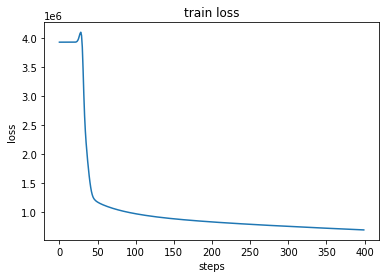

In [ ]:
_ = eval_model(train, 
            test, 
            logistic_model,
            transform_y,
            opti_function = partial(gradient_descent, 
                                    loss_function=calculate_loss, 
                                    grad_function=calculate_gradient,
                                    lambda_=0,
                                    max_iters=400, 
                                    gamma=1e-9))

We have problem optmizing, very low learning rate, slow, and suboptimal results. What if we normalize.

loss 297085.5988338461  w norm 3.1504252829879817 gamma 5e-06
loss 112460.18467814907  w norm 1.7763778068705498 gamma 5e-06
loss 111997.89036249324  w norm 2.076065284464855 gamma 5e-06
loss 111881.92872165643  w norm 2.2450261762238926 gamma 5e-06
loss 111836.0058060079  w norm 2.353819441073383 gamma 5e-06
test results
###################
train error 111814.71645248057
test accuracy 0.73004
###################


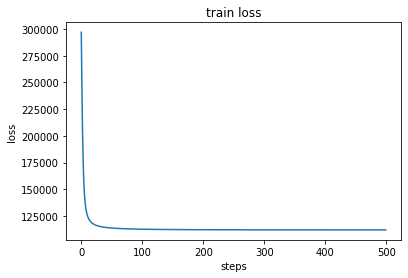

In [ ]:
_ = eval_model(train, 
            test, 
            logistic_model,
            transform_y_and_normalize(),
            opti_function = partial(gradient_descent, 
                                    loss_function=calculate_loss, 
                                    grad_function=calculate_gradient,
                                    lambda_=0,
                                    max_iters=500, 
                                    gamma=5e-6))

We achieve more or less same accurracy, but it takes more time to train. We try to augment it with some expansions

####Feature augmentation

#####Helpers

In [ ]:
def expand_features(dataset, expansions):
  feature_name = ['bias'] + dataset.feature_name
  features = [np.ones((dataset.x.shape[0],1)), dataset.x] 

  for expansion in expansions:
    f_name, f = expansion(dataset)
    feature_name = feature_name + f_name
    features.append(f)
  
  return Dataset().with_values(np.concatenate(features, axis=1),
                               dataset.y,
                               feature_name)

def ploy_expand(power, ds):
  f_name = [ f'{f}^{power}' for f in ds.feature_name]
  return f_name, ds.x**power

def sin_expand(ds):
   f_name = [ f'{f}-sin' for f in ds.feature_name]
   return f_name, np.sin(ds.x)

def cos_expand(ds):
  f_name = [ f'{f}-cos' for f in ds.feature_name]
  return f_name, np.cos(ds.x)

def log_expand(ds, min_features):
  f_name = [f'{f}-log' for f in ds.feature_name]
  x = ds.x-min_features+1
  x[x<1] = 1

  return f_name, np.log(x)

####we want all features to be greater than 0 for the log expansion otherwise the logarithm is not defined
min_features = np.min(dataset.x, axis=0)
log_exp = partial(log_expand, min_features=min_features) 


def augment_with(expansions):
  return lambda dataset: expand_features(dataset, expansions)

def normalize_with(expansions):
  normalize = Normalize_mean()

  return lambda dataset: normalize(expand_features(dataset, expansions))

def augment_with_logistic(expansions):
  normalize = normalize_with(expansions)
  return lambda dataset: normalize(transform_y(dataset))

#####Main code

In [ ]:
augmentations = [[], [sin_expand], [cos_expand], [log_exp]]
names = ['none','sin','cos','log']

for i, augmentation in enumerate(augmentations):
  _, _, _, _, acc_test = eval_model(train, 
            test, 
            linear_model,
            preprocess = augment_with(augmentation),
            opti_function = partial(ridge_regression, lambda_=0),
            print_result=False)
  
  print(f'accuracy {acc_test} : {names[i]}')

accuracy 0.7467 : none
accuracy 0.7613 : sin
accuracy 0.76294 : cos
accuracy 0.7768 : log


All features improve the accuracy. Now we see, what happens when we use multiple feature augmentation.

In [ ]:
augmentations = [sin_expand, cos_expand, log_exp]+ [partial(ploy_expand,i) for i in range(2,12)]

losses_train = []
losses_test = []
train_accs = []
test_accs = []

for loop in range(3):  #we repeat the procedure three times to see if the solver is robust and we get similar results
  loss_train_ = []
  loss_test_ = []
  train_acc_ = []
  test_acc_ = []

  dataset_train, dataset_test = dataset.split(0.8)

  for i in range(len(augmentations)):
    _, loss_train, loss_test, train_acc, test_acc = eval_model(dataset_train, 
            dataset_test, 
            linear_model,
            augment_with(augmentations[:i]),
            opti_function = partial(ridge_regression, lambda_=0),
            print_result=False)
  
    loss_train_.append(loss_train)
    loss_test_.append(loss_test)
    train_acc_.append(train_acc)
    test_acc_.append(test_acc)
  
  losses_train.append(loss_train_)
  losses_test.append(loss_test_)
  train_accs.append(train_acc_)
  test_accs.append(test_acc_)


maximum test accurracy 0.80548
maximum test accurracy 0.80628
maximum test accurracy 0.81556


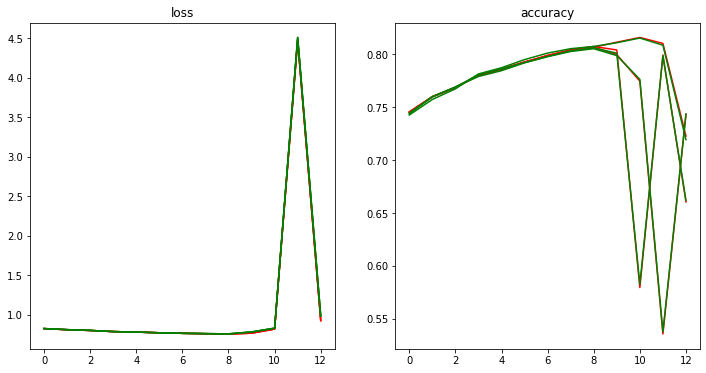

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs[0].set_title('loss')

for loss_train in losses_train:
  axs[0].plot(losses_train[0], color='red')

for loss_test in losses_test:
  axs[0].plot(losses_test[0], color='green')

axs[1].set_title('accuracy')

for train_acc in train_accs:
  axs[1].plot(train_acc, color='red')

for test_acc in test_accs:
  axs[1].plot(test_acc, color='green')
  print(f'maximum test accurracy {max(test_acc)}')

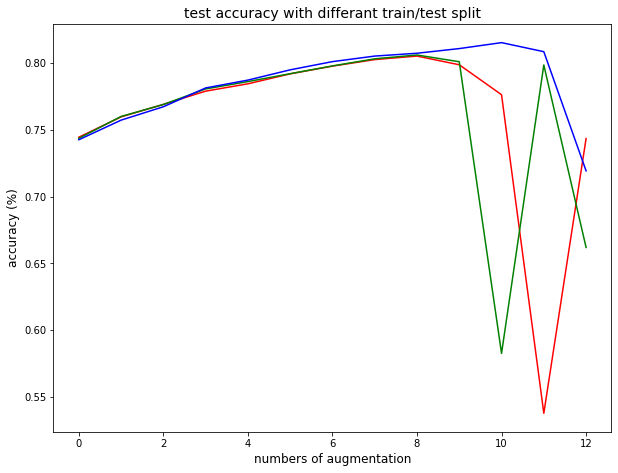

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7.5))
ax.plot(test_accs[0], color='red')
ax.plot(test_accs[1], color='green')
ax.plot(test_accs[2], color='blue')
ax.set_title('test accuracy with differant train/test split', fontsize=14)
ax.set_xlabel('numbers of augmentation', fontsize=12)
ax.set_ylabel('accuracy (%)', fontsize=12)
fig.savefig('not robust')

It seems that after the 9 first features the solver is not robust. Maybe adding a regulariser can compensate.We have pretty consistant results.

In [ ]:
augmentations = [sin_expand, cos_expand, log_exp]+[partial(ploy_expand,i) for i in range(2,16)]
lambdas_ = np.logspace(-5,0, num=10)

test_accs = []

for i in range(10, len(augmentations)):
  accs = []
  for lambda_ in lambdas_:
    

    _, _, _, _, test_acc = eval_model(train, 
            test, 
            linear_model,
            augment_with(augmentations[:i]),
            opti_function = partial(ridge_regression, lambda_=lambda_),
            print_result=False)
    
    accs.append(test_acc)
    
  test_accs.append(accs)


In [ ]:
print(f'best accuracy {max([x for line in test_accs for x in line])}')
print(f'best lambda {"{:.2e}".format(lambdas_[3])} best augmentation {13} accuracy {test_accs[3][3]}')

best accuracy 0.81588
best lambda 4.64e-04 best augmentation 13 accuracy 0.81532


why should we take this lambda? the previous one give us a better accuracy

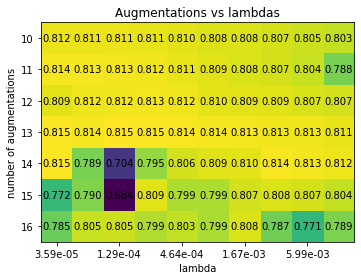

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(test_accs)

ax.set_xticklabels(["{:.2e}".format(lambda_) for lambda_ in lambdas_])
ax.set_xlabel('lambda')
ax.set_ylabel('number of augmentations')

ax.set_yticklabels(range(9, len(augmentations)))



# Loop over data dimensions and create text annotations.
for i in range(len(test_accs)):
    for j in range(len(lambdas_)):
        text = ax.text(j, i, str(test_accs[i][j])[:5],
                       ha="center", va="center", color="black")


ax.set_title("Augmentations vs lambdas")
fig.tight_layout()
fig.savefig('reg_aug_vs_lambda')
plt.show()

We see that as we increase the number of features, there is more fluctuations in the solutions. An accuracy arround 0.817 seems to be the most we can achieve within this setup.

######Features augmentation on regulated logistic regression

In [ ]:
augmentations = [sin_expand, cos_expand, log_exp]+ [partial(ploy_expand,i) for i in range(2,12)]
lambdas_ = np.logspace(-9,-5, num=10)
test_accs2 = []
#This takes around 30min of computation, so DON'T recompute this exept for very good reason

for augmentation in augmentations:
  accs = []
  for lambda_ in lambdas_:
    
    



    _, _, _, _, test_acc = eval_model(train, 
                                      test, 
                                      logistic_model,
                                      augment_with_logistic(augmentations[:i]),
                                      opti_function = partial(gradient_descent, 
                                                              loss_function=calculate_loss, 
                                                              grad_function=calculate_gradient,
                                                              lambda_=lambda_,
                                                              max_iters=200, 
                                                              gamma=lambda_, print_result=False))
    
    accs.append(test_acc)
  test_accs2.append(accs)

In [ ]:
fig, ax = plt.subplots(figsize=(6,16))
im = ax.imshow(test_accs2)

ax.set_xticklabels(["{:.2e}".format(lambda_) for lambda_ in lambdas_])
ax.set_xlabel('lambda = gamma')
ax.set_ylabel('augmentation')



# Loop over data dimensions and create text annotations.
for i in range(len(augmentations)):
    for j in range(len(lambdas_)):
        text = ax.text(j, i, str(test_accs2[i][j])[:5],ha="center", va="center", color="black")


ax.set_title("Augmentations vs lambdas=gammas with normalisation")
fig.tight_layout()
plt.show()
#Thus, the optimal number of extensions is 3 why is 3?

In [ ]:
augmentations = [sin_expand, cos_expand, log_exp]+[partial(ploy_expand,3)]
lambdas_ = np.logspace(-6.5,-5.5, num=5)
gammas = np.logspace(-6.5,-5.5, num=5)
test_accs4 = []
#This takes around 30min of computation, so DON'T recompute this exept for very good reason

for gamma in gammas:
  accs = []
  for lambda_ in lambdas_:
    
    



    _, _, _, _, test_acc = eval_model(train, 
                                      test, 
                                      logistic_model,
                                      augment_with_logistic(augmentations),
                                      opti_function = partial(gradient_descent, 
                                                              loss_function=calculate_loss, 
                                                              grad_function=calculate_gradient,
                                                              lambda_=lambda_,
                                                              max_iters=200, 
                                                              gamma=gamma, print_result=False))
    
    accs.append(test_acc)
  test_accs4.append(accs)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(test_accs4)

ax.set_xticklabels(["{:.2e}".format(lambda_) for lambda_ in lambdas_])
ax.set_yticklabels(["{:.2e}".format(gamma) for gamma in gammas])
ax.set_xlabel('lambda')
ax.set_ylabel('gamma')



# Loop over data dimensions and create text annotations.
for i in range(len(gammas)):
    for j in range(len(lambdas_)):
        text = ax.text(j, i, str(test_accs4[i][j])[:5],ha="center", va="center", color="black")


ax.set_title("lambdas vs gammas with optimal augmentation")
fig.tight_layout()
plt.show()


In [ ]:
#Our optimal solution for rlr
test_acc = eval_model(train, 
                                      test, 
                                      logistic_model,
                                      augment_with_logistic([sin_expand, cos_expand, log_exp]+[partial(ploy_expand,0)] +[partial(ploy_expand,2)] +[partial(ploy_expand,3)]),
                                      opti_function = partial(gradient_descent, 
                                                              loss_function=calculate_loss, 
                                                              grad_function=calculate_gradient,
                                                              lambda_=1e-06,
                                                              max_iters=400, 
                                                              gamma=1.78e-06, print_result=False))

##Submission

In [ ]:
 augmentations = [sin_expand, cos_expand, log_exp]+[partial(ploy_expand,i) for i in range(2,16)]
 w, _, _, _, _ = eval_model(train, 
            test, 
            linear_model,
            augment_with(augmentations[:13]),
            opti_function = partial(ridge_regression, lambda_=4.64e-04),
            print_result=True)



test results
###################
train error 0.7351602310126513
test accuracy 0.81522
###################


In [ ]:
ids = load_ids('test.csv')
prediction_dataset = Dataset().from_path('test.csv')
prediction_dataset.x.shape

(568238, 30)

In [ ]:
replace_wrong_data(prediction_dataset)

def preprocess(dataset):
  return augment_with(augmentations[:13])(dataset)

augmented_prediction_dataset = preprocess(prediction_dataset)

In [ ]:
predictions, _ = linear_model(w,augmented_prediction_dataset.x, augmented_prediction_dataset.y)
predictions.shape

(568238,)

In [ ]:
create_csv_submission(ids, predictions, 'submission_2')

#Function that were implemented 

In [ ]:
#####helpers
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [ ]:
import numpy as np




def compute_mse(y, tx, w):
    """compute the loss by mse."""
    e = y - (tx@w) 
    return 0.5*np.mean(e**2)

def compute_rmse(y, tx, w):
    """compute the loss by mse."""
    mse = compute_mse(y, tx, w)
    return np.sqrt(2*mse)


def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e = y - tx@w 
    N = len(y)
    return -tx.T@e/N



#########optimisation

def least_square_GD(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    w = initial_w
    for n_iter in range(max_iters):
        grad=compute_gradient(y,tx,w)
        w=w-gamma*grad
        loss=compute_mse(y,tx,w)
   

    return w, loss


def least_squares_SGD(y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    ws=[initial_w]
    losses=[]
    w=initial_w
    for n_iter in range(max_iters):
      for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
        loss=compute_mse(y,tx, w)
        stoch_grad=compute_gradient(minibatch_y,minibatch_tx,w)
        w=w-gamma*stoch_grad
        ws.append(w)
        losses.append(loss)
    return losses[-1], ws[-1] #return all the ws computed by the gradient and not only the final one




def least_squares(y, tx):
    """calculate the least squares."""
    # ***************************************************
    # returns optimal weights, MSE
    # ***************************************************
    target = tx.T@y
    x_t_x = tx.T@tx
    w = np.linalg.solve(x_t_x,target)
    return w, compute_mse(y, tx, w) #compute mse and not rmse right?



def ridge_regression(y, tx, lambda_):
  #compute the ridge regression of y = tx.w
  #return weights and loss (in MSE)
  N=tx.shape[0]
  lambda_prime = 2*N*lambda_
  G=np.transpose(tx).dot(tx) + lambda_prime*np.eye(tx.shape[1])
  w = np.linalg.solve(G, np.transpose(tx).dot(y))
  loss= compute_mse(y,tx,w)  #lambda_*((np.linalg.norm(w))**2)
  return w, loss


def logistic_function(x):
  return 1/(1+np.exp(-x))

def calculate_loss(y, tx, w):
  """compute the loss: negative log likelihood."""
  prediction = logistic_function(tx@w) 
  prediction[prediction == 0]= 0.0000000000001
  prediction[prediction == 1]= 0.9999999999999  
  loss_per_prediction = y*np.log(prediction) + (1-y)*np.log(1-prediction)
  return -loss_per_prediction.sum()

def calculate_gradient(y, tx, w):
  """compute the gradient of loss."""
  # ***************************************************
  prediction=logistic_function(tx@w)
  gradient = tx.T.dot(prediction - y)
  return gradient

def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """
    loss=calculate_loss(y, tx, w)
    grad=calculate_gradient(y,tx,w)
    w= w-gamma*grad
    return loss, w


def logistic_regression_gradient_descent(y, tx, initial_w, max_iters, gamma):
    threshold = 1e-8 #we need to find the right threshold
    losses = [] ##do we want to store the losses?
    w = initial_w

    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return w, loss


def hessian(y,tx,w):
    pred = logistic_function(tx.dot(w))
    pred = np.diag(pred.T[0])
    S= np.multiply(pred, (1-pred))
    return tx.T.dot(S).dot(tx)

    
def logistic_regression(y,tx,w):
    loss=calculate_loss(y,tx,w) 
    grad= calculate_gradient(y,tx,w)
    H = calculate_hessian(y,tx,w)
    return loss, grad, H

def learning_by_newton_method(y, tx, w, gamma):
    """
    Do one step on Newton's method.
    return the loss and updated w.
    """
    loss, H, grad = logistic_regression(y,tx,w)
    w =w-np.linalg.solve(H, grad)
    return loss, w

def hessian_logistic_regression(y,tx,initial_w, max_iters, gamma, lambda_):
  for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_newton_method(y, tx, w, gamma)
    # log info
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
      break
  return loss, w

def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss, gradient"""
    # ***************************************************
    loss=calculate_loss(y,tx,w) # lambda_*((np.linalg.norm(w))**2) right?
    grad= calculate_gradient(y, tx, w) + 2*lambda_*w
    return loss, grad
def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    # ***************************************************
    loss, grad = penalized_logistic_regression(y, tx, w, lambda_)
    w =w -grad*gamma   
    return loss, w

def reg_logistic_regression_GD(y, tx, lambda_, initial_w, max_iters, gamma):
  threshold = 1e-8
  losses = []
  w=initial_w
  # start the logistic regression
  for iter in range(max_iters):
    # get loss and update w.
    loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
    losses.append(loss)
  
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
      break
  return w, losses[-1]
    